DXG

In [1]:
# 1. Import thư viện cần thiết

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [2]:
# 2. Đọc file csv và gắng index với giá Close
dxg = pd.read_csv('../../DATASET/DXG.csv')
qcg = pd.read_csv('../../DATASET/QCG.csv')
vhm = pd.read_csv('../../DATASET/VHM.csv')

def remove_commas_and_convert(x):
    return float(x.replace(',', ''))
# Áp dụng hàm cho toàn bộ DataFrame
dxg = dxg['Close'].apply(remove_commas_and_convert)
qcg = qcg['Close'].apply(remove_commas_and_convert)
vhm = vhm['Close'].apply(remove_commas_and_convert)

dxg1=dxg.reset_index()['Close']
qcg1=qcg.reset_index()['Close']
vhm1=vhm.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))

dxg1=scaler.fit_transform(np.array(dxg1).reshape(-1,1))
qcg1=scaler.fit_transform(np.array(qcg1).reshape(-1,1))
vhm1=scaler.fit_transform(np.array(vhm1).reshape(-1,1))

In [4]:
# 4. Chia train test
#DXG
dxg_train_size = int(0.9 * len(dxg1))
dxg_test_size = len(dxg1) - dxg_train_size 
dxg_train_data = dxg1[:dxg_train_size]
dxg_test_data = dxg1[dxg_train_size:dxg_train_size+dxg_test_size]



#QCG
qcg_train_size = int(0.9 * len(qcg1))
qcg_test_size = len(qcg1) - qcg_train_size 
qcg_train_data = qcg1[:qcg_train_size]
qcg_test_data = qcg1[qcg_train_size:qcg_train_size+qcg_test_size]


#VHM
vhm_train_size = int(0.9 * len(vhm1))
vhm_test_size = len(vhm1) - vhm_train_size 
vhm_train_data = vhm1[:vhm_train_size]
vhm_test_data = vhm1[vhm_train_size:vhm_train_size+vhm_test_size]


In [5]:
len(dxg_train_data)

1126

In [6]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [7]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100
#DXG
time_step = 100
dxg_X_train, dxg_y_train = create_dataset(dxg_train_data, time_step)
# dxg_X_val, dxg_yval = create_dataset(dxg_val_data, time_step)
dxg_X_test, dxg_ytest = create_dataset(dxg_test_data, time_step)

#QCG
qcg_X_train, qcg_y_train = create_dataset(qcg_train_data, time_step)
# qcg_X_val, qcg_yval = create_dataset(qcg_val_data, time_step)
qcg_X_test, qcg_ytest = create_dataset(qcg_test_data, time_step)


#VHM
vhm_X_train, vhm_y_train = create_dataset(vhm_train_data, time_step)
# vhm_X_val, vhm_yval = create_dataset(vhm_val_data, time_step)
vhm_X_test, vhm_ytest = create_dataset(vhm_test_data, time_step)

In [8]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
dxg_X_train =dxg_X_train.reshape(dxg_X_train.shape[0],dxg_X_train.shape[1] , 1)
dxg_X_test = dxg_X_test.reshape(dxg_X_test.shape[0],dxg_X_test.shape[1] , 1)
# dxg_X_val = dxg_X_val.reshape(dxg_X_val.shape[0],dxg_X_val.shape[1] , 1)

qcg_X_train =qcg_X_train.reshape(qcg_X_train.shape[0],qcg_X_train.shape[1] , 1)
qcg_X_test = qcg_X_test.reshape(qcg_X_test.shape[0],qcg_X_test.shape[1] , 1)
# qcg_X_val = qcg_X_val.reshape(qcg_X_val.shape[0],qcg_X_val.shape[1] , 1)

vhm_X_train =vhm_X_train.reshape(vhm_X_train.shape[0],vhm_X_train.shape[1] , 1)
vhm_X_test = vhm_X_test.reshape(vhm_X_test.shape[0],vhm_X_test.shape[1] , 1)
# vhm_X_val = vhm_X_val.reshape(vhm_X_val.shape[0],vhm_X_val.shape[1] , 1)

In [9]:
# 8. Define RNN Model

dxg_model = Sequential()
dxg_model.add(SimpleRNN(50, input_shape=(time_step, 1)))
dxg_model.add(Dense(1))
dxg_model.compile(optimizer='adam', loss='mean_squared_error')

qcg_model = Sequential()
qcg_model.add(SimpleRNN(50, input_shape=(time_step, 1)))
qcg_model.add(Dense(1))
qcg_model.compile(optimizer='adam', loss='mean_squared_error')

vhm_model = Sequential()
vhm_model.add(SimpleRNN(50, input_shape=(time_step, 1)))
vhm_model.add(Dense(1))
vhm_model.compile(optimizer='adam', loss='mean_squared_error')


c:\Users\Khang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 9. Fit mô hình với dữ liệu train
dxg_model.fit(dxg_X_train,dxg_y_train,validation_data=(dxg_X_test,dxg_ytest),epochs=100,batch_size=64,verbose=1)
qcg_model.fit(qcg_X_train,qcg_y_train,validation_data=(qcg_X_test,qcg_ytest),epochs=100,batch_size=64,verbose=1)
vhm_model.fit(vhm_X_train,vhm_y_train,validation_data=(vhm_X_test,vhm_ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100


17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0204 - val_loss: 5.4896e-04
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0022 - val_loss: 5.1181e-04
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0013 - val_loss: 3.7134e-04
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0011 - val_loss: 2.9495e-04
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 9.7301e-04 - val_loss: 2.7516e-04
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 9.3964e-04 - val_loss: 2.5088e-04
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.5748e-04 - val_loss: 2.9639e-04
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 9.2872e-04 - val_loss: 3.7036e-04
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0010 - val_loss: 2.1334e-04
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 8.9298e-04 - val_loss: 2.5433e-04
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.6359e-04 - val_loss: 2.5001e

In [11]:
# 10. Dự báo dữ liệu test, val
dxg_train_predict=dxg_model.predict(dxg_X_train)
dxg_y_pred=dxg_model.predict(dxg_X_test)
# dxg_y_pred_val=dxg_model.predict(dxg_X_val)

qcg_train_predict=qcg_model.predict(qcg_X_train)
qcg_y_pred=qcg_model.predict(qcg_X_test)

vhm_train_predict=vhm_model.predict(vhm_X_train)
vhm_y_pred=vhm_model.predict(vhm_X_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [12]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
dxg_train_predict=scaler.inverse_transform(dxg_train_predict)
dxg_y_pred=scaler.inverse_transform(dxg_y_pred)
# dxg_y_pred_val=scaler.inverse_transform(dxg_y_pred_val)

qcg_train_predict=scaler.inverse_transform(qcg_train_predict)
qcg_y_pred=scaler.inverse_transform(qcg_y_pred)

vhm_train_predict=scaler.inverse_transform(vhm_train_predict)
vhm_y_pred=scaler.inverse_transform(vhm_y_pred)

In [20]:
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error

#DXG
actual=scaler.inverse_transform(dxg_test_data)
actual= actual[101:]
forecast = dxg_y_pred 
rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
mae = mean_absolute_error(actual, forecast)

print('DXG')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"Mae: {mae}\n")

#QCG
actual=scaler.inverse_transform(qcg_test_data)
actual= actual[101:]
forecast = qcg_y_pred 
rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
mae = mean_absolute_error(actual, forecast)
print('QCG')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"Mae: {mae}\n")


# VHM
actual=scaler.inverse_transform(vhm_test_data)
actual= actual[101:]
forecast = vhm_y_pred 
rmse = np.sqrt(np.mean((forecast - actual)**2))
mape = np.mean(np.abs((actual - forecast) / actual))
mae = mean_absolute_error(actual, forecast)

print('VHM')
print('RMSE:', rmse)
print('MAPE: ', mape)
print(f"Mae: {mae}\n")

DXG
RMSE: 603.6047536650887
MAPE:  0.009842871404330846
Mae: 495.17954621389043

QCG
RMSE: 789.1202997554731
MAPE:  0.013719653936909115
Mae: 600.0304149899401

VHM
RMSE: 1490.4113127741339
MAPE:  0.017240706440394313
Mae: 1188.336875



In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=dxg_test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

dxg_lst_output=[]
n_steps=100
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = dxg_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        dxg_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, 66,1))
        yhat = dxg_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        dxg_lst_output.extend(yhat.tolist())
        i=i+1


[0.26291198]
67
[0.26291198]
68
[0.26291198]
69
[0.26291198]
70
[0.26291198]
71
[0.26291198]
72
[0.26291198]
73
[0.26291198]
74
[0.26291198]
75
[0.26291198]
76
[0.26291198]
77
[0.26291198]
78
[0.26291198]
79
[0.26291198]
80
[0.26291198]
81
[0.26291198]
82
[0.26291198]
83
[0.26291198]
84
[0.26291198]
85
[0.26291198]
86
[0.26291198]
87
[0.26291198]
88
[0.26291198]
89
[0.26291198]
90
[0.26291198]
91
[0.26291198]
92
[0.26291198]
93
[0.26291198]
94
[0.26291198]
95
[0.26291198]
96
[0.26291198]
97
[0.26291198]
98
[0.26291198]
99
[0.26291198]
100
[0.26291198]
101
35 day input [0.13914208 0.13572302 0.13401598 0.14426819 0.15537516 0.15537516
 0.15537516 0.15793696 0.16050126 0.1647726  0.15622743 0.15622743
 0.15452039 0.15452039 0.15879173 0.16135353 0.15622743 0.1596465
 0.16050126 0.15622743 0.13743255 0.15110132 0.15879173 0.18271271
 0.19211265 0.19552922 0.19552922 0.19894579 0.19723875 0.20492666
 0.20749096 0.19211265 0.20749096 0.21090753 0.21603363 0.21517886
 0.21261706 0.2194527  0

In [15]:
# 13. Dự báo 30 ngày tiếp theo
x_input=qcg_test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

qcg_lst_output=[]
n_steps=100
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = qcg_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        qcg_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1,66,1))
        yhat = qcg_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        qcg_lst_output.extend(yhat.tolist())
        i=i+1


[0.07430888]
67
[0.07430888]
68
[0.07430888]
69
[0.07430888]
70
[0.07430888]
71
[0.07430888]
72
[0.07430888]
73
[0.07430888]
74
[0.07430888]
75
[0.07430888]
76
[0.07430888]
77
[0.07430888]
78
[0.07430888]
79
[0.07430888]
80
[0.07430888]
81
[0.07430888]
82
[0.07430888]
83
[0.07430888]
84
[0.07430888]
85
[0.07430888]
86
[0.07430888]
87
[0.07430888]
88
[0.07430888]
89
[0.07430888]
90
[0.07430888]
91
[0.07430888]
92
[0.07430888]
93
[0.07430888]
94
[0.07430888]
95
[0.07430888]
96
[0.07430888]
97
[0.07430888]
98
[0.07430888]
99
[0.07430888]
100
[0.07430888]
101
35 day input [0.07947686 0.08249497 0.09104628 0.09205231 0.09205231 0.0915493
 0.0915493  0.0915493  0.09205231 0.08903421 0.09557344 0.09959759
 0.10211268 0.10311871 0.10462777 0.09959759 0.08249497 0.08249497
 0.08148893 0.08199195 0.08953722 0.09406439 0.08953722 0.09708249
 0.09959759 0.09657948 0.10211268 0.10462777 0.10714286 0.09808853
 0.10965795 0.09909457 0.11217304 0.13279678 0.15492958 0.15291751
 0.13229376 0.13480885 0

In [16]:
# 13. Dự báo 30 ngày tiếp theo
x_input=vhm_test_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

vhm_lst_output=[]
n_steps=100
i=0
while(i<90):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = vhm_model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        vhm_lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, 66,1))
        yhat = vhm_model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        vhm_lst_output.extend(yhat.tolist())
        i=i+1


[0.61036223]
67
[0.61036223]
68
[0.61036223]
69
[0.61036223]
70
[0.61036223]
71
[0.61036223]
72
[0.61036223]
73
[0.61036223]
74
[0.61036223]
75
[0.61036223]
76
[0.61036223]
77
[0.61036223]
78
[0.61036223]
79
[0.61036223]
80
[0.61036223]
81
[0.61036223]
82
[0.61036223]
83
[0.61036223]
84
[0.61036223]
85
[0.61036223]
86
[0.61036223]
87
[0.61036223]
88
[0.61036223]
89
[0.61036223]
90
[0.61036223]
91
[0.61036223]
92
[0.61036223]
93
[0.61036223]
94
[0.61036223]
95
[0.61036223]
96
[0.61036223]
97
[0.61036223]
98
[0.61036223]
99
[0.61036223]
100
[0.61036223]
101
35 day input [0.44062301 0.44062301 0.44062301 0.46156906 0.47054026 0.48549889
 0.484007   0.49745385 0.49896563 0.52886299 0.52886299 0.53186665
 0.53335853 0.53186665 0.5363423  0.52138367 0.50644494 0.50644494
 0.49148631 0.49896563 0.51541614 0.54980904 0.56625955 0.5872056
 0.60216423 0.61113542 0.58420194 0.57672263 0.56625955 0.58121817
 0.56625955 0.56625955 0.5782344  0.5961768  0.6305697  0.63355347
 0.61861474 0.63804901 0

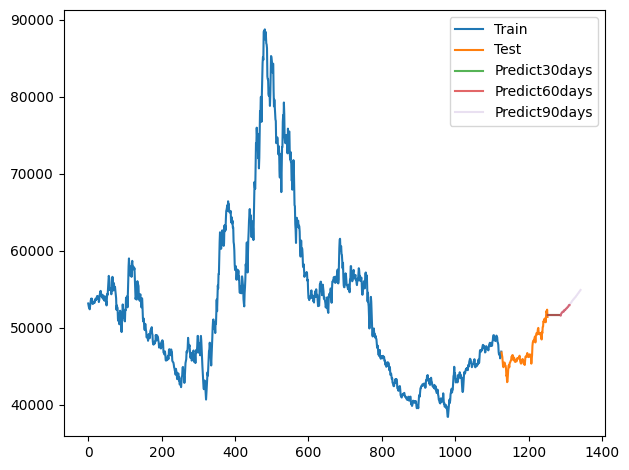

In [17]:
# 14.Vẽ hình
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#DXG
dxg_train_data_index = pd.RangeIndex(start=0, stop=dxg_train_size, step=1)
plt.plot(scaler.inverse_transform(dxg_train_data))
dxg_test_data_index = pd.RangeIndex(start=dxg_train_size, stop=dxg_train_size+dxg_test_size, step=1)
plt.plot(dxg_test_data_index,scaler.inverse_transform(dxg_test_data))
dxg_predict_data_30= pd.RangeIndex(start=len(dxg1),stop=len(dxg1) + 30,step=1)
dxg_predict_data_60= pd.RangeIndex(start=len(dxg1),stop=len(dxg1) + 60,step=1)
dxg_predict_data_90= pd.RangeIndex(start=len(dxg1),stop=len(dxg1) + 90,step=1)
plt.plot(dxg_predict_data_30,scaler.inverse_transform(dxg_lst_output[:30]), alpha=0.8)
plt.plot(dxg_predict_data_60,scaler.inverse_transform(dxg_lst_output[:60]), alpha=0.7)
plt.plot(dxg_predict_data_90,scaler.inverse_transform(dxg_lst_output[:90]),alpha=0.2)
plt.legend(['Train','Test','Predict30days','Predict60days','Predict90days'])


plt.tight_layout()
plt.show()

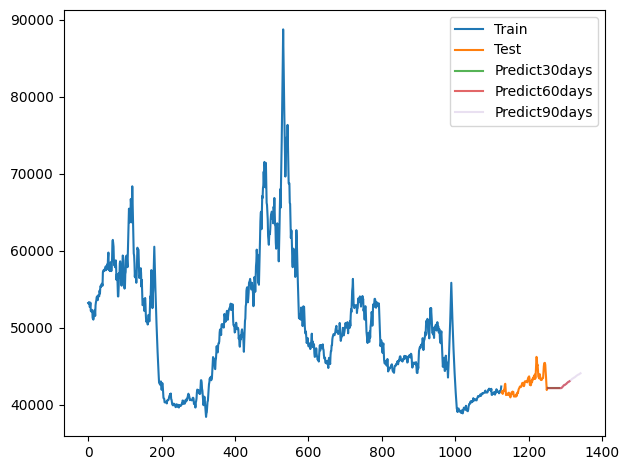

In [18]:
#qcg
qcg_train_data_index = pd.RangeIndex(start=0, stop=qcg_train_size, step=1)
plt.plot(scaler.inverse_transform(qcg_train_data))
qcg_test_data_index = pd.RangeIndex(start=qcg_train_size, stop=qcg_train_size+qcg_test_size, step=1)
plt.plot(qcg_test_data_index,scaler.inverse_transform(qcg_test_data))
qcg_predict_data_30= pd.RangeIndex(start=len(qcg1),stop=len(qcg1) + 30,step=1)
qcg_predict_data_60= pd.RangeIndex(start=len(qcg1),stop=len(qcg1) + 60,step=1)
qcg_predict_data_90= pd.RangeIndex(start=len(qcg1),stop=len(qcg1) + 90,step=1)
plt.plot(qcg_predict_data_30,scaler.inverse_transform(qcg_lst_output[:30]), alpha=0.8)
plt.plot(qcg_predict_data_60,scaler.inverse_transform(qcg_lst_output[:60]), alpha=0.7)
plt.plot(qcg_predict_data_90,scaler.inverse_transform(qcg_lst_output[:90]),alpha=0.2)
plt.legend(['Train','Test','Predict30days','Predict60days','Predict90days'])


plt.tight_layout()
plt.show()

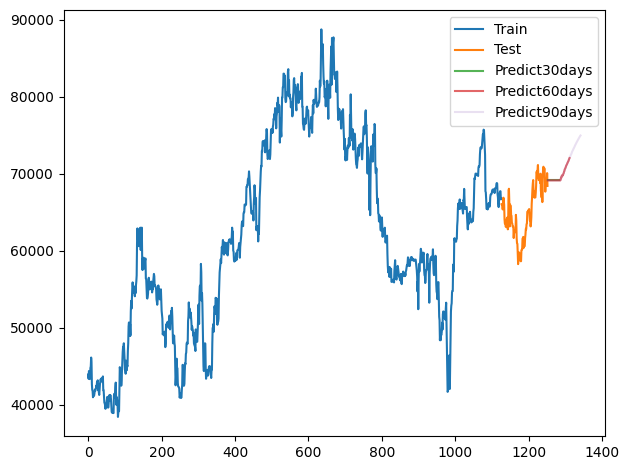

In [19]:
#DXG
vhm_train_data_index = pd.RangeIndex(start=0, stop=vhm_train_size, step=1)
plt.plot(scaler.inverse_transform(vhm_train_data))
vhm_test_data_index = pd.RangeIndex(start=vhm_train_size, stop=vhm_train_size+vhm_test_size, step=1)
plt.plot(vhm_test_data_index,scaler.inverse_transform(vhm_test_data))
vhm_predict_data_30= pd.RangeIndex(start=len(vhm1),stop=len(vhm1) + 30,step=1)
vhm_predict_data_60= pd.RangeIndex(start=len(vhm1),stop=len(vhm1) + 60,step=1)
vhm_predict_data_90= pd.RangeIndex(start=len(vhm1),stop=len(vhm1) + 90,step=1)
plt.plot(vhm_predict_data_30,scaler.inverse_transform(vhm_lst_output[:30]), alpha=0.8)
plt.plot(vhm_predict_data_60,scaler.inverse_transform(vhm_lst_output[:60]), alpha=0.7)
plt.plot(vhm_predict_data_90,scaler.inverse_transform(vhm_lst_output[:90]),alpha=0.2)
plt.legend(['Train','Test','Predict30days','Predict60days','Predict90days'])


plt.tight_layout()
plt.show()